# EDA california housing

## Cài đặt và nhập thư viện vào notebook

In [1]:
# !pip install bayesian-optimization
# !pip install statsmodels
# !pip install xgboost

In [2]:
#!pip install matplotlib seaborn scikit-learn scipy 

In [3]:
# ========== Cảnh báo & Luồng xử lý ==========
import warnings
import math
import threading
warnings.filterwarnings('ignore')


# ========== Thư viện xử lý dữ liệu ==========
import pandas as pd
pd.set_option('display.precision', 2) 
import numpy as np

# ========== Thư viện trực quan hoá ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Xử lý & tiền xử lý dữ liệu ==========
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# ========== PCA ==========
from sklearn.decomposition import PCA

# ========== Thư viện mô hình học máy ==========
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ========== Đánh giá mô hình ==========
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== Kiểm tra đa cộng tuyến ==========
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ========== Kiểm định giả định phân phối ==========
import scipy.stats as stats
from scipy.stats import shapiro

# ========== Tối ưu hoá mô hình ==========
from bayes_opt import BayesianOptimization

# ========== Dữ liệu mẫu ==========
from sklearn.datasets import fetch_california_housing

## 1. Tiền xử lý dữ liệu

### Tải dữ liệu California Housing từ scikit-learn datasets (fetch_california_housing)

In [4]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['PRICE'] = housing.target

### Làm sạch dữ liệu: xử lý giá trị thiếu, loại bỏ ngoại lai

In [5]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB



**California Housing Dataset** – Mô tả tổng quan


- **Kích thước**:  
  - ~20.640 dòng (mẫu)  
  - 9 cột (8 đặc trưng + 1 biến mục tiêu `PRICE`)

Các biến trong dataset:

| Tên biến       | Kiểu dữ liệu | Mô tả |
|----------------|--------------|-------|
| `MedInc`       | float        | Thu nhập trung vị của hộ gia đình trong đơn vị 10.000 USD |
| `HouseAge`     | float        | Tuổi trung bình của các ngôi nhà trong khu vực |
| `AveRooms`     | float        | Số phòng trung bình mỗi hộ |
| `AveBedrms`    | float        | Số phòng ngủ trung bình mỗi hộ |
| `Population`   | float        | Số dân cư trong khu vực |
| `AveOccup`     | float        | Số người trung bình trên mỗi hộ |
| `Latitude`     | float        | Vĩ độ địa lý |
| `Longitude`    | float        | Kinh độ địa lý |
| `PRICE`        | float        | Giá nhà trung bình (đơn vị 100.000 USD) – **biến mục tiêu**


#### kiểm tra null, dupplicated

In [7]:
missing_values = data.isnull().sum()
duplicates = data.duplicated().sum()

# Kiểm tra giá trị thiếu
if missing_values.sum() == 0:
    print("Không có giá trị thiếu trong dữ liệu.")
else:
    print("Các cột có giá trị thiếu:")

Không có giá trị thiếu trong dữ liệu.


In [8]:
# Kiểm tra giá trị trùng lặp
if duplicates == 0:
    print("Không có dòng dữ liệu trùng lặp.")
else:
    print(f"Có {duplicates} dòng trùng lặp trong dữ liệu.")

Không có dòng dữ liệu trùng lặp.


In [9]:
# Tính IQR và xác định outlier cho từng cột
def detect_outliers_iqr(df):
    outlier_info = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = {
            "outlier_count": outliers.shape[0],
            "outlier_percent": round(100 * outliers.shape[0] / df.shape[0], 2),
            # "lower_bound": lower_bound,
            # "upper_bound": upper_bound
        }
    return pd.DataFrame(outlier_info).T.sort_values(by="outlier_count", ascending=False)
# Gọi hàm
detect_outliers_iqr(data)

,outlier_count,outlier_percent
AveBedrms,1424.0,6.90
Population,1196.0,5.79
PRICE,1071.0,5.19
AveOccup,711.0,3.44
MedInc,681.0,3.30
AveRooms,511.0,2.48
HouseAge,0.0,0.00
Latitude,0.0,0.00
Longitude,0.0,0.00


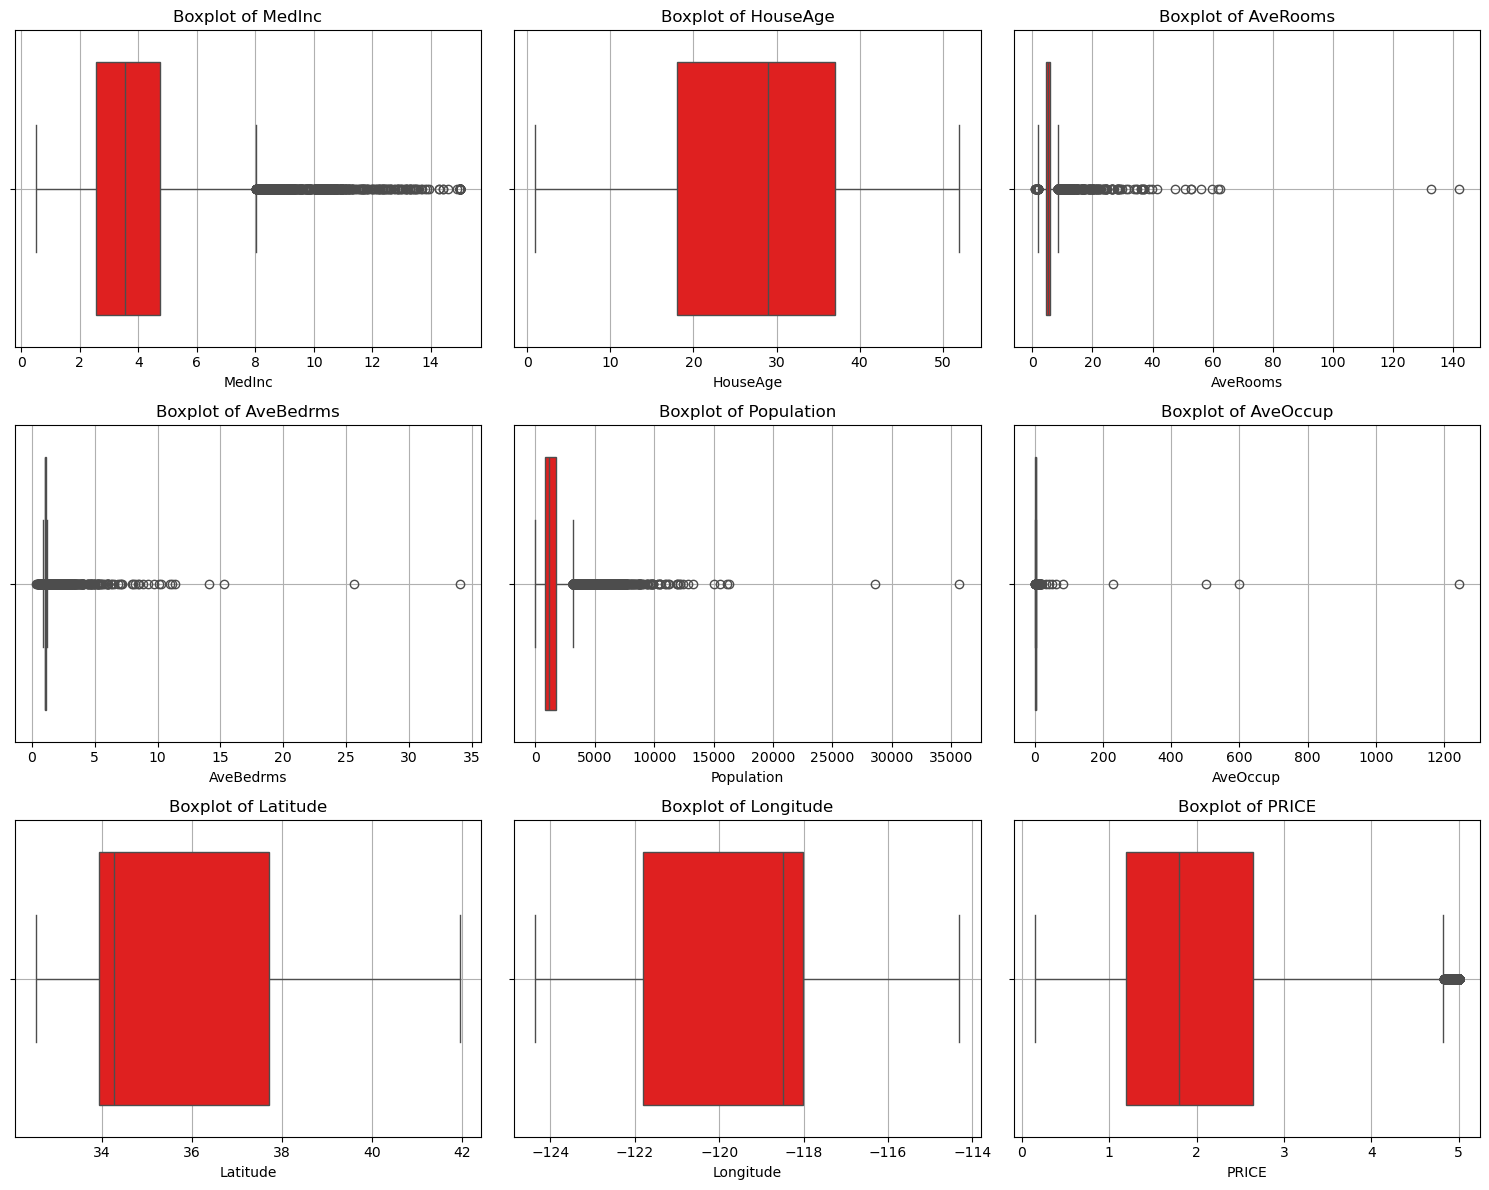

In [10]:
#Trực quan cụ thể outlier trên từng biến
cols = data.columns
n_cols = 3  # số cột mỗi hàng
n_rows = 3  # số hàng mỗi trang
plots_per_page = n_cols * n_rows
total = len(cols)
pages = math.ceil(total / plots_per_page)

for page in range(pages):
    start = page * plots_per_page
    end = min(start + plots_per_page, total)
    current_cols = cols[start:end]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(current_cols):
        sns.boxplot(x=data[col], ax=axes[i], color='red')
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].grid(True)

    # Ẩn subplot còn dư
    for j in range(len(current_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [11]:
def plot_histograms(df, cols, n_rows=2, n_cols=3, bins=30, color='blue'):
    """
    Vẽ nhiều histogram kèm KDE cho các cột trong DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        cols (list): Danh sách tên cột cần vẽ.
        n_rows (int): Số hàng trong grid subplot.
        n_cols (int): Số cột trong grid subplot.
        bins (int): Số lượng bins cho histogram.
        color (str): Màu của biểu đồ.
    """
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], bins=bins, kde=True, color=color)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

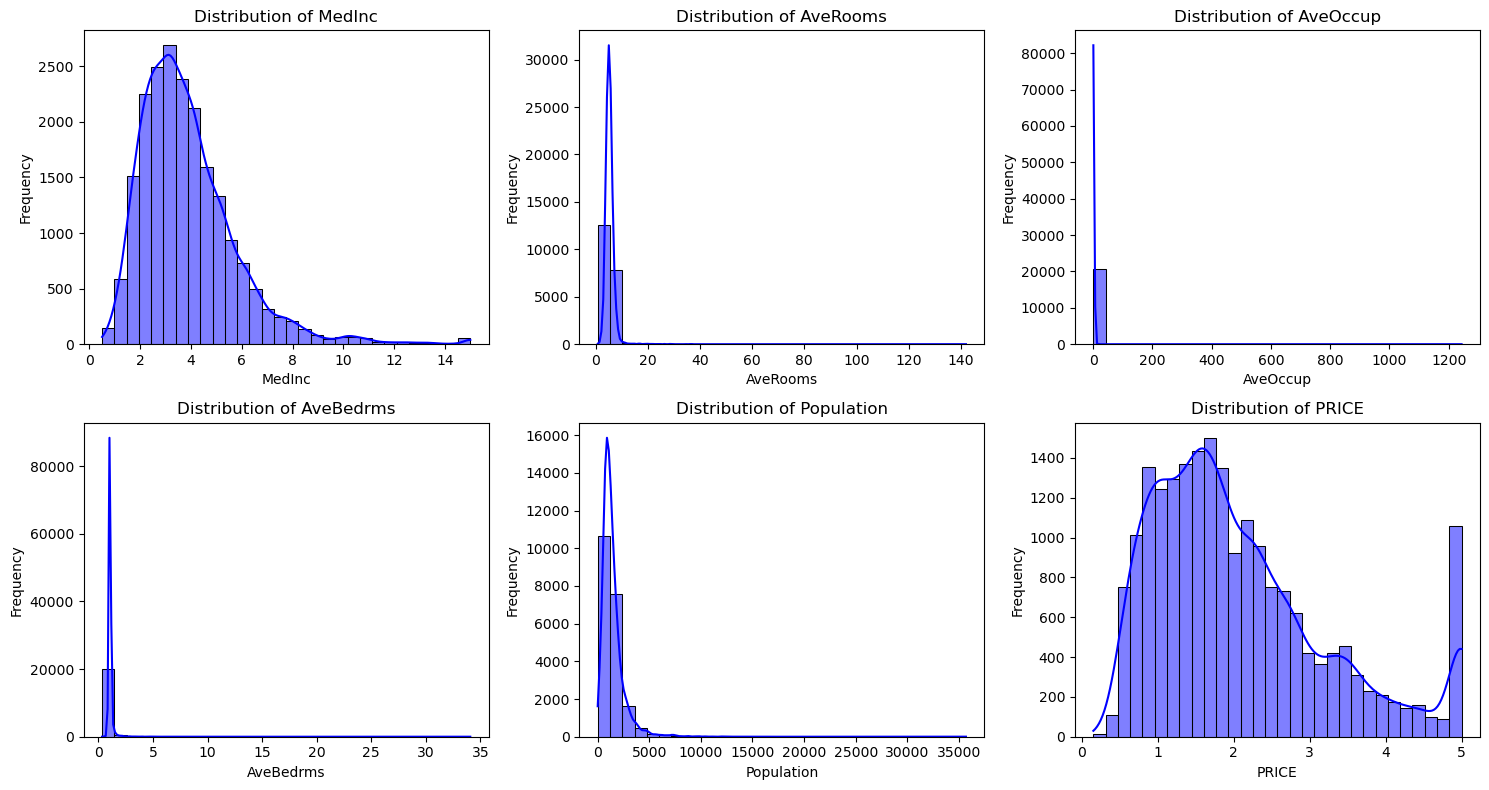

In [12]:
# Danh sách biến cần vẽ
cols = ['MedInc','AveRooms','AveOccup','AveBedrms', 'Population', 'PRICE']
plot_histograms(data, cols, n_rows=2, n_cols=3)

Dựa trên kết quả kiểm tra outlier bằng phương pháp IQR, có thể rút ra một số kết luận sau:

Ba biến `HouseAge`, `Latitude` và `Longitude` không xuất hiện giá trị ngoại lai, cho thấy dữ liệu của chúng tương đối ổn định và nằm trong giới hạn hợp lý của tập mẫu. Đây thường là các biến mang tính địa lý hoặc giới hạn tự nhiên, nên không bị ảnh hưởng bởi giá trị cực đoan.

Ngược lại, các biến còn lại đều có outlier, trong đó `AveBedrms`, `Population` và `PRICE` là những biến có tỷ lệ ngoại lai cao nhất, lần lượt là 6.9%, 5.79% và 5.19%. Điều này phản ánh sự phân bố không đồng đều của dữ liệu ở một số khu vực, chẳng hạn như số phòng ngủ trung bình quá cao, dân cư tập trung quá đông, hoặc giá nhà vượt xa mức trung bình chung. Những biến này có thể cần xử lý hoặc kiểm tra thêm để đảm bảo tính ổn định của mô hình phân tích.

Các biến như `AveOccup`, `MedInc` và `AveRooms` cũng có outlier nhưng ở mức trung bình. Tùy vào mục đích nghiên cứu, những giá trị này có thể được giữ lại nếu phản ánh đúng đặc trưng thực tế của dữ liệu, hoặc được biến đổi để giảm ảnh hưởng đến kết quả phân tích.


In [13]:
def drop_outliers_percentile(df, cols,  lower=0, upper=0.97):
    for col in cols:
        low = df[col].quantile(lower)
        high = df[col].quantile(upper)
        df.dropna(inplace= True)
        df = df[(df[col] >= low) & (df[col] <= high)]  # Lọc từng cột một
    return df

In [14]:
# Đếm số dòng trước và sau khi drop
before = len(data)
data = drop_outliers_percentile(data, cols)
after = len(data)
print(f"Đã loại {before - after} dòng chứa outlier.")

Đã loại 3451 dòng chứa outlier.


In [15]:
detect_outliers_iqr(data)

,outlier_count,outlier_percent
Population,635.0,3.69
AveBedrms,500.0,2.91
PRICE,240.0,1.40
AveOccup,170.0,0.99
MedInc,150.0,0.87
AveRooms,67.0,0.39
HouseAge,0.0,0.00
Latitude,0.0,0.00
Longitude,0.0,0.00


### tổng kết 
* Có nhiều phương pháp để drop outlier, tuy nhiên đây là phương pháp dễ hiểu nhất dùng để giải thích biểu đồ. Mục đích chính là cắt đuôi dài đằng sau, làm mất đi cái phân phối siêu lệch phải đó.

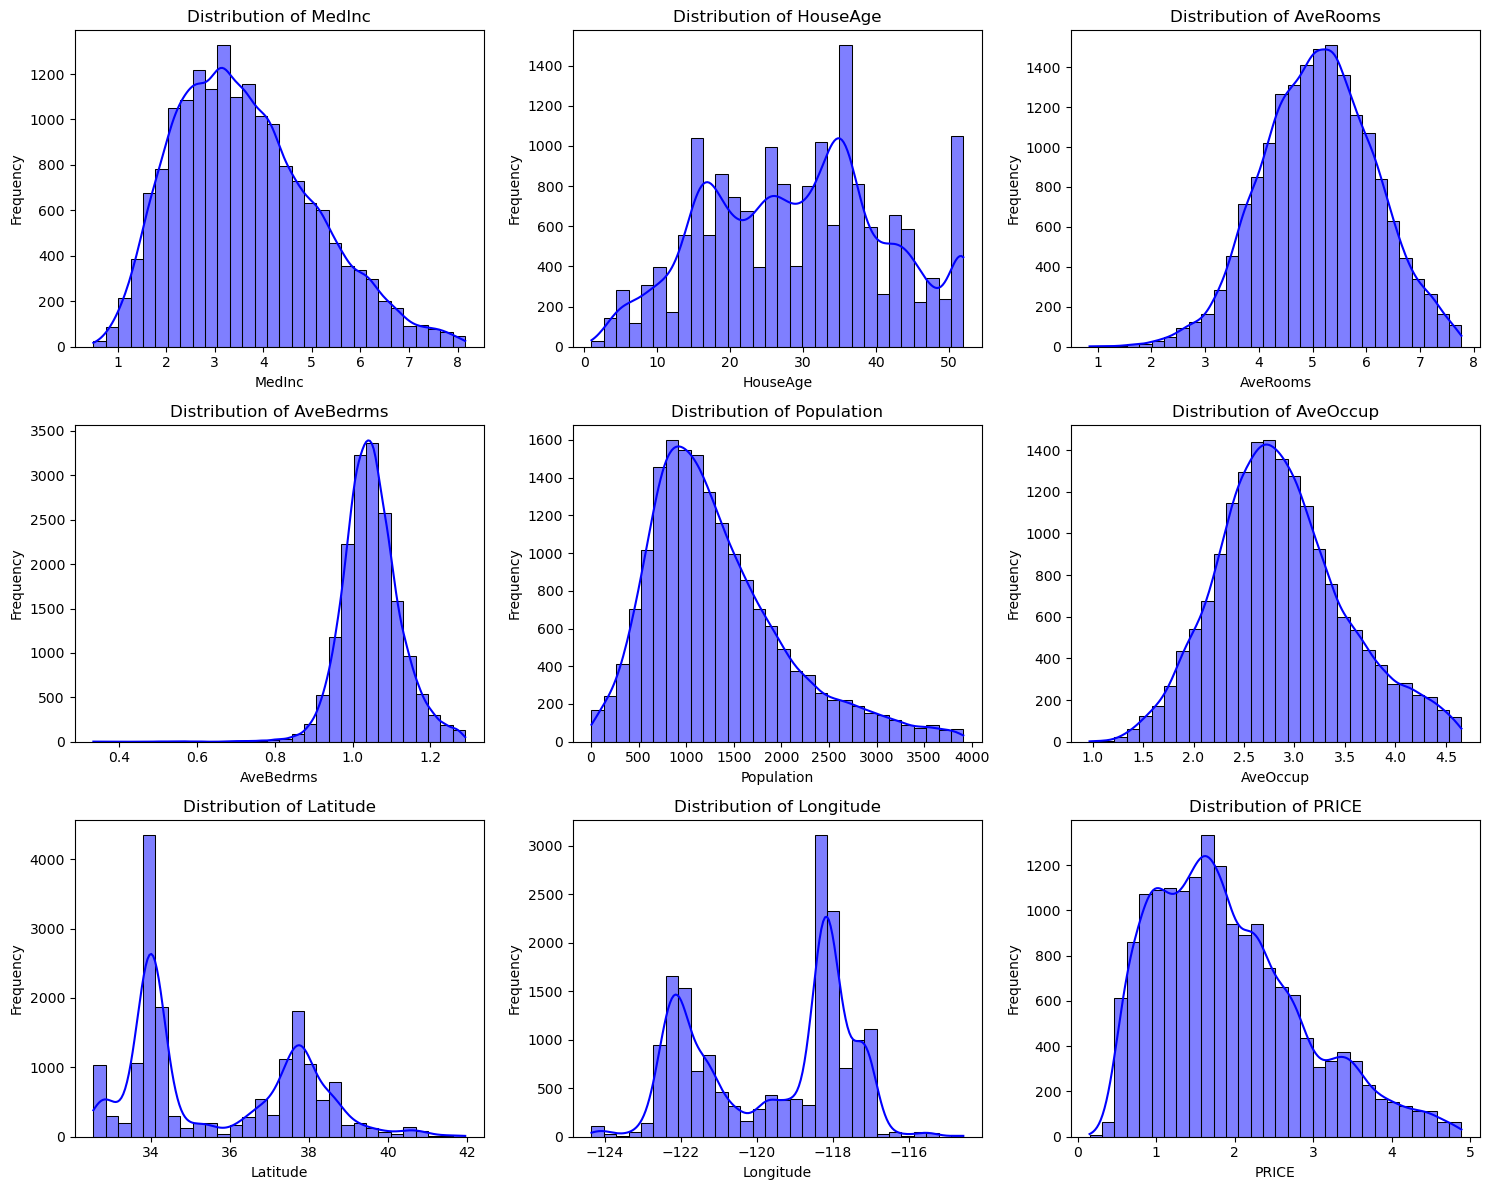

In [16]:
# Lấy tất cả các cột trong data_transformed
cols = data.columns
plot_histograms(data, cols, n_rows=3, n_cols=3)

### Kiểm tra, phân loại biến, chuyển các biến định tính về dạng số 

In [17]:
desc = data.describe().T

In [18]:
#Phân loại các cột
categorical_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

In [19]:
# Thống kê cho categorical features
print("Categorical Features:")
print("=================================")
for feature in categorical_features:
    print(f"{feature}:\n{data[feature].value_counts()}\n")

Categorical Features:


Không có biến nào là biến định tính

In [20]:
# Thống kê cho numerical features
print("Numerical Features:")
# Thống kê mô tả chung cho dữ liệu số
data[numerical_features].describe()

Numerical Features:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,17189.00,17189.00,17189.00,17189.00,17189.00,17189.00,17189.00,17189.00,17189.00
mean,3.63,29.27,5.12,1.05,1323.17,2.88,35.66,-119.61,1.92
std,1.43,12.28,1.04,0.07,723.76,0.64,2.14,2.00,0.94
min,0.50,1.00,0.85,0.33,5.00,0.97,32.54,-124.35,0.15
25%,2.54,19.00,4.40,1.00,812.00,2.44,33.94,-121.81,1.18
50%,3.46,30.00,5.12,1.04,1171.00,2.82,34.28,-118.55,1.76
75%,4.54,37.00,5.83,1.09,1685.00,3.26,37.73,-118.03,2.48
max,8.16,52.00,7.77,1.29,3911.00,4.65,41.95,-114.57,4.89


Mặc dù tất cả các biến trong tập dữ liệu California Housing đều được định dạng dạng số và được hệ thống thống kê xem là biến định lượng, tuy nhiên qua quá trình trực quan hóa và phân tích phân phối, một số biến thể hiện hành vi như biến định tính. Đặc biệt là các biến như HouseAge, AveOccup, AveBedrms, Latitude, và Longitude có phân phối cụm, nhiễu cao hoặc mang ý nghĩa phân loại vùng. Mục đích của nhóm là  chuyển những biến này sang dạng định tính (categorical) giúp mô hình học tốt hơn và giảm thiểu nhiễu từ giá trị không mang ý nghĩa toán học.



#####  **Phân tích phân phối và đề xuất chuyển đổi biến định lượng thành định tính**

Để hiểu rõ hơn về bản chất các biến trong tập dữ liệu California Housing, nhóm đã trực quan hóa phân phối của một số biến định lượng bằng biểu đồ histogram. Mặc dù các biến này được hệ thống phân loại là dạng số, kết quả trực quan cho thấy nhiều biến có hành vi tương tự biến định tính. Cụ thể:

###### 1. `HouseAge` – Tuổi trung bình của nhà ở khu vực
Biểu đồ phân phối của biến `HouseAge` cho thấy dữ liệu được gom thành các cụm rõ rệt tại các mức tuổi tròn như 15, 20, 30, 35 và 50. Điều này phản ánh thực tế là các khu dân cư thường được xây dựng theo từng đợt và có tuổi nhà đồng đều. Do vậy, việc giữ `HouseAge` dưới dạng số liên tục có thể gây nhiễu cho mô hình. Thay vào đó, có thể nhóm thành ba mức: nhà mới (0–20 năm), nhà trung niên (21–40 năm) và nhà cũ (>40 năm).

###### 2. `AveOccup` – Số người trung bình trên mỗi hộ
Biến này có phân phối gần chuẩn, tập trung mạnh quanh giá trị 2.5–3.5. Tuy nhiên, do phần lớn giá trị rơi vào khoảng hẹp, các mức cao và thấp mang tính bất thường và có thể ảnh hưởng đến mô hình tuyến tính. Việc phân nhóm thành các mức "thấp", "trung bình" và "cao" sẽ giúp làm mượt dữ liệu và tăng khả năng tổng quát hóa của mô hình.

###### 3. `AveBedrms` – Số phòng ngủ trung bình mỗi hộ
Dù biểu đồ gần giống phân phối chuẩn, dữ liệu tập trung gần như tuyệt đối quanh khoảng 1.0–1.1. Điều này cho thấy sự biến thiên là rất nhỏ và khó mang lại giá trị khi sử dụng như biến định lượng. Việc phân loại biến này theo các ngưỡng có thể giúp mô hình hiểu rõ ranh giới giữa khu vực ít phòng ngủ và nhiều phòng ngủ hơn.

###### 4. `Latitude` và `Longitude` – Tọa độ địa lý
Hai biến tọa độ có phân phối thành từng cụm dân cư rõ ràng. Điều này phản ánh sự tập trung dân số tại các khu đô thị lớn như Los Angeles, San Francisco, v.v. Tọa độ không nên được đưa vào mô hình như các giá trị liên tục do không có ý nghĩa toán học theo trục tọa độ. Do đó, nên nhóm các khu vực này thành các vùng địa lý như Bắc California, Trung California và Nam California để phản ánh đặc điểm vùng.

##### Kết luận:
Mặc dù các biến nêu trên có dạng số, trực quan hóa đã chỉ ra hành vi phân loại ẩn trong phân phối dữ liệu. Việc chuyển đổi một số biến định lượng thành định tính không chỉ phù hợp về mặt logic mà còn giúp tăng độ linh hoạt, khả năng học của mô hình và cải thiện khả năng diễn giải kết quả.


#### Chuyển biến định tính về dạng số

In [21]:
data_binned = data.copy()

# Rời rạc hóa các biến nghi ngờ có tính chất định tính ẩn bằng nhãn số
data_binned['HouseAge_cat'] = pd.cut(data_binned['HouseAge'],
                                     bins=[0, 20, 40, data_binned['HouseAge'].max()],
                                     labels=[1, 2, 3])

data_binned['AveOccup_cat'] = pd.cut(data_binned['AveOccup'],
                                     bins=[0, 2, 4, data_binned['AveOccup'].max()],
                                     labels=[1, 2, 3])

data_binned['AveBedrms_cat'] = pd.cut(data_binned['AveBedrms'],
                                      bins=[0, 1.0, 1.1, data_binned['AveBedrms'].max()],
                                      labels=[1, 2, 3])

data_binned['Region_lat'] = pd.cut(data_binned['Latitude'],
                                   bins=[32, 35, 37.5, 42],
                                   labels=[1, 2, 3])

data_binned['Region_long'] = pd.cut(data_binned['Longitude'],
                                    bins=[-125, -122, -119, -114],
                                    labels=[1, 2, 3])

# Chuyển tất cả thành kiểu category
categorical_cols = ['HouseAge_cat', 'AveOccup_cat', 'AveBedrms_cat', 'Region_lat', 'Region_long']
data_binned[categorical_cols] = data_binned[categorical_cols].astype('category')

# Mô tả thống kê các biến định tính
data_binned[categorical_cols].describe()

,HouseAge_cat,AveOccup_cat,AveBedrms_cat,Region_lat,Region_long
count,17189,17189,17189,17189,17189
unique,3,3,3,3,3
top,2,2,2,1,3
freq,8996,14838,9394,9230,8953


In [22]:
data_binned

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE,HouseAge_cat,AveOccup_cat,AveBedrms_cat,Region_lat,Region_long
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41,3,2,2,3,1
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42,3,2,2,3,1
5,4.04,52.0,4.76,1.10,413.0,2.14,37.85,-122.25,2.70,3,2,3,3,1
6,3.66,52.0,4.93,0.95,1094.0,2.13,37.84,-122.25,2.99,3,2,1,3,1
7,3.12,52.0,4.80,1.06,1157.0,1.79,37.84,-122.25,2.41,3,1,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20634,3.71,28.0,6.78,1.15,1041.0,3.03,39.27,-121.56,1.17,2,2,3,3,2
20635,1.56,25.0,5.05,1.13,845.0,2.56,39.48,-121.09,0.78,2,2,3,3,2
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22,0.92,1,2,3,3,2
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32,0.85,1,2,3,3,2


## 2. Khám phá dữ liệu và trực quan hóa

### Vẽ biểu đồ phân phối, scatter plot để phân tích mối quan hệ giữa các biến

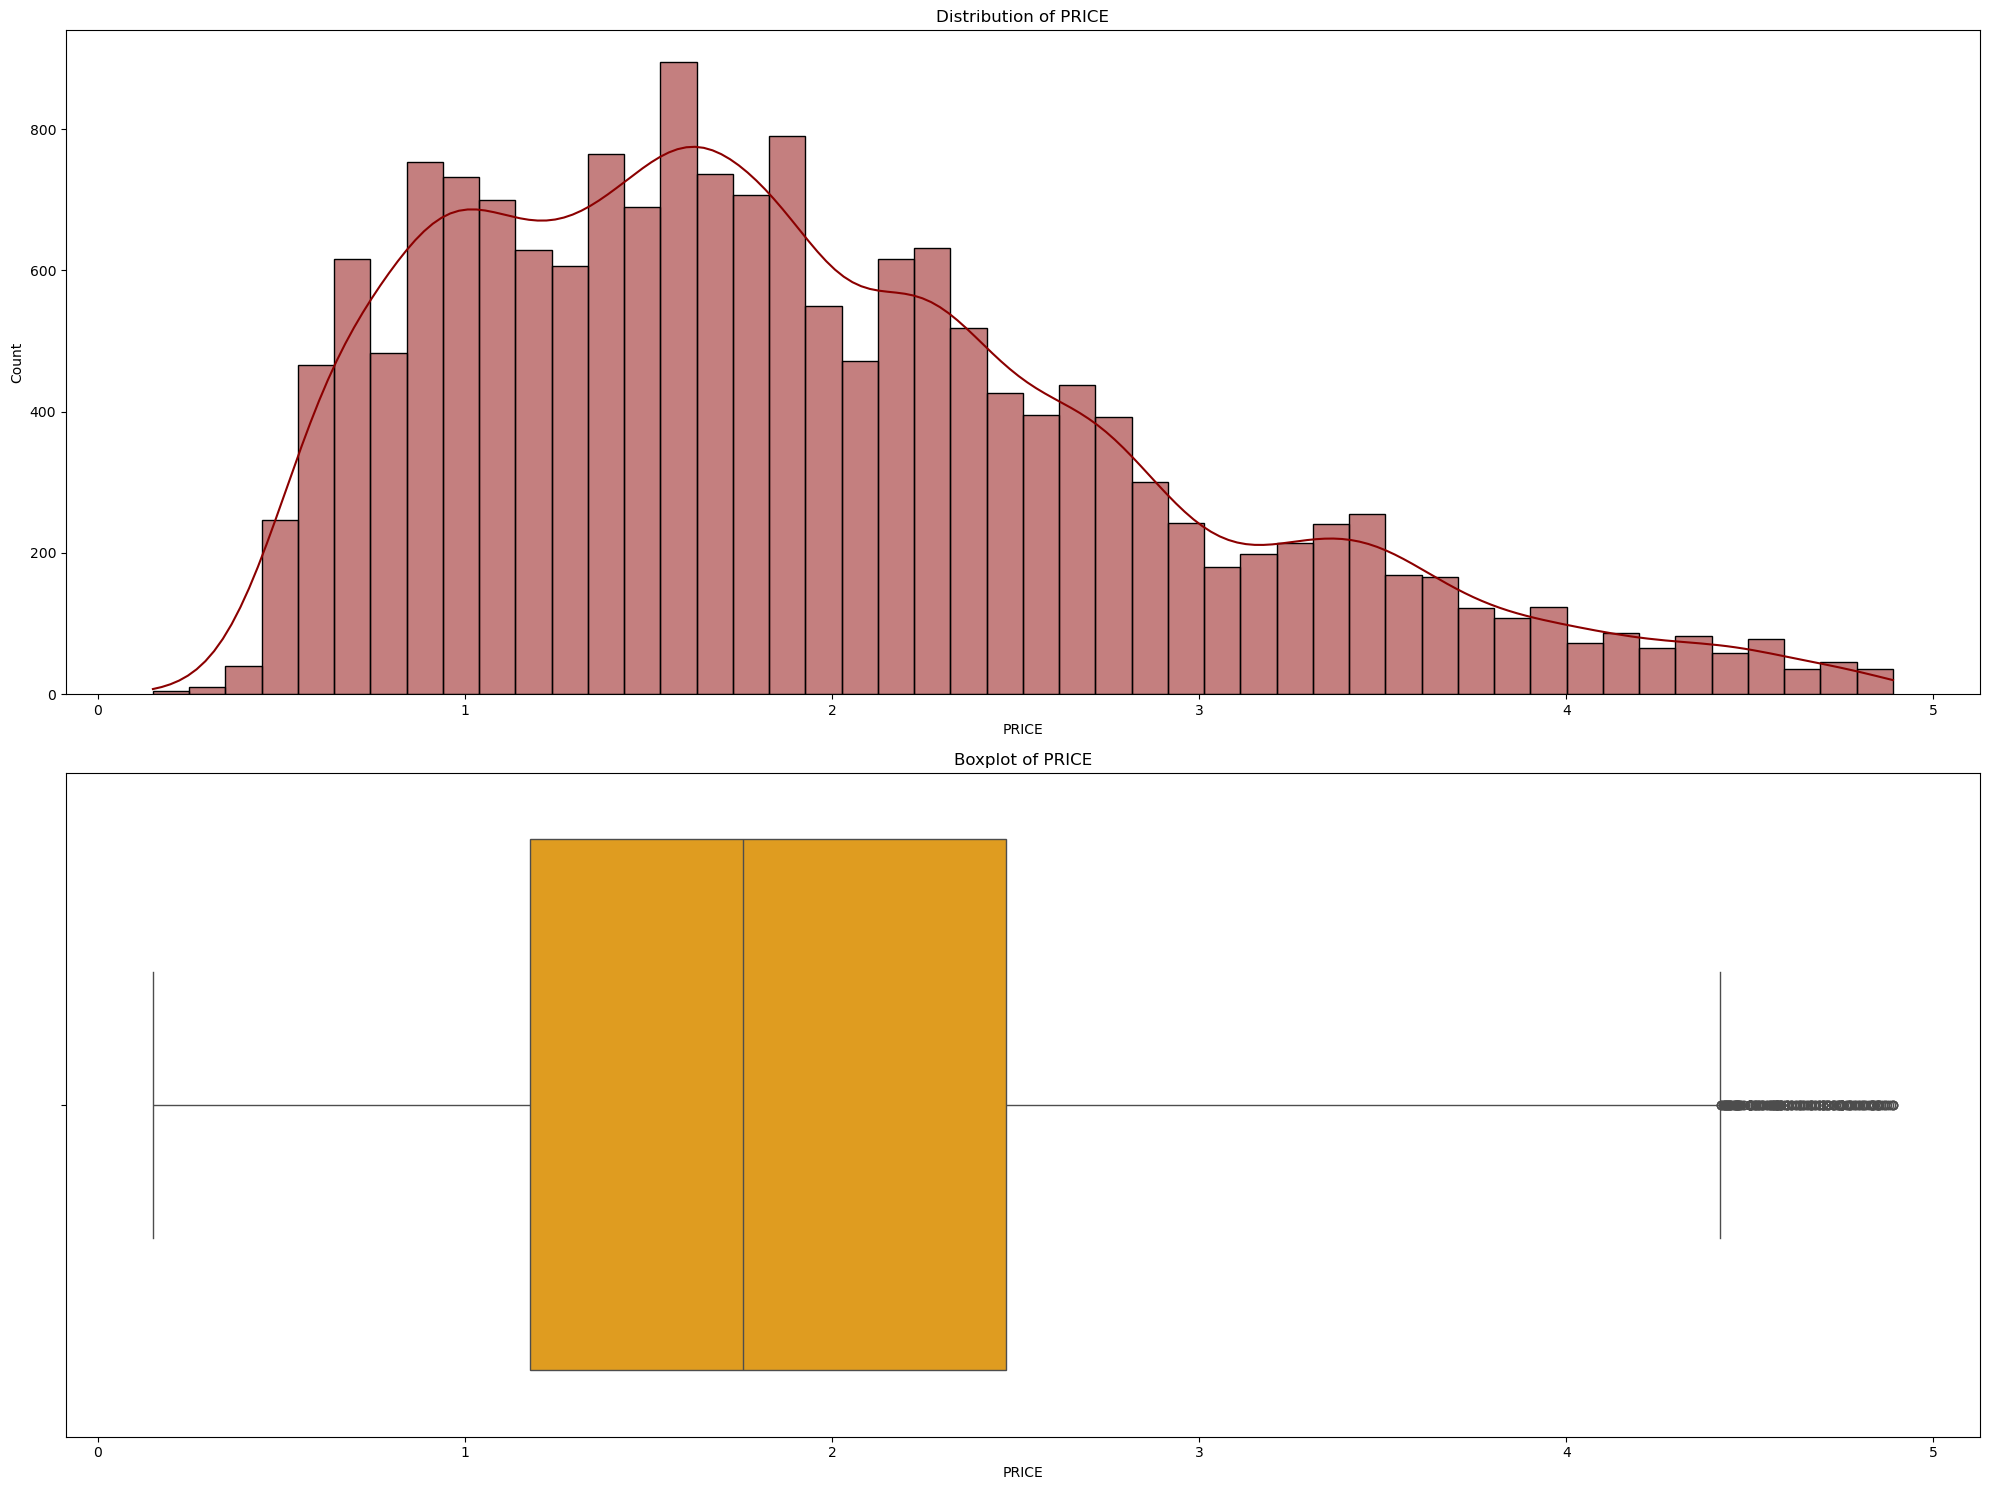

In [23]:
# Thiết lập kích thước tổng cho cả hình
plt.figure(figsize=(20, 15))

# Biểu đồ 1: Phân phối của PRICE (histogram + KDE)
plt.subplot(2, 1, 1)  # dòng 1, cột 1, vị trí 1
sns.histplot(data['PRICE'], kde=True, color='darkred')
plt.title('Distribution of PRICE')

# Biểu đồ 2: Boxplot của PRICE
plt.subplot(2, 1, 2)  # dòng 2, cột 1, vị trí 2
sns.boxplot(x=data['PRICE'], color='orange')
plt.title('Boxplot of PRICE')

# Hiển thị cả hai biểu đồ
plt.tight_layout()
plt.show()

### Kết luận về biểu đồ phân phối và boxplot của `PRICE`

- Biểu đồ histogram cho thấy **phân phối của `PRICE` bị lệch phải rõ rệt**, với phần đuôi kéo dài về phía các giá trị lớn.
- Đường KDE thể hiện có thể tồn tại **hai đỉnh phân phối**, cho thấy khả năng có 2 nhóm giá nhà khác biệt.
- Boxplot chỉ ra rằng có **nhiều outlier ở phía bên phải**, tương ứng với các căn nhà có giá rất cao.
- Median nằm lệch về trái, xác nhận sự **mất cân đối trong phân phối**.
- Đây là một ví dụ điển hình của **phân phối siêu lệch phải**, thường gặp trong dữ liệu giá nhà.

Trong bối cảnh **làm dashboard phân tích**, **không nên loại bỏ outlier**. Thay vào đó:
- Giữ nguyên dữ liệu để phản ánh **toàn cảnh thị trường**.
- Có thể dùng thêm biểu đồ zoom (cắt ở percentile 95%) hoặc trục log để **phân tích chi tiết hơn phần trung tâm**.

Outlier trong trường hợp này **không phải là nhiễu**, mà là **một phần quan trọng của insight**.


#### Mối quan hệ giữa features -> target

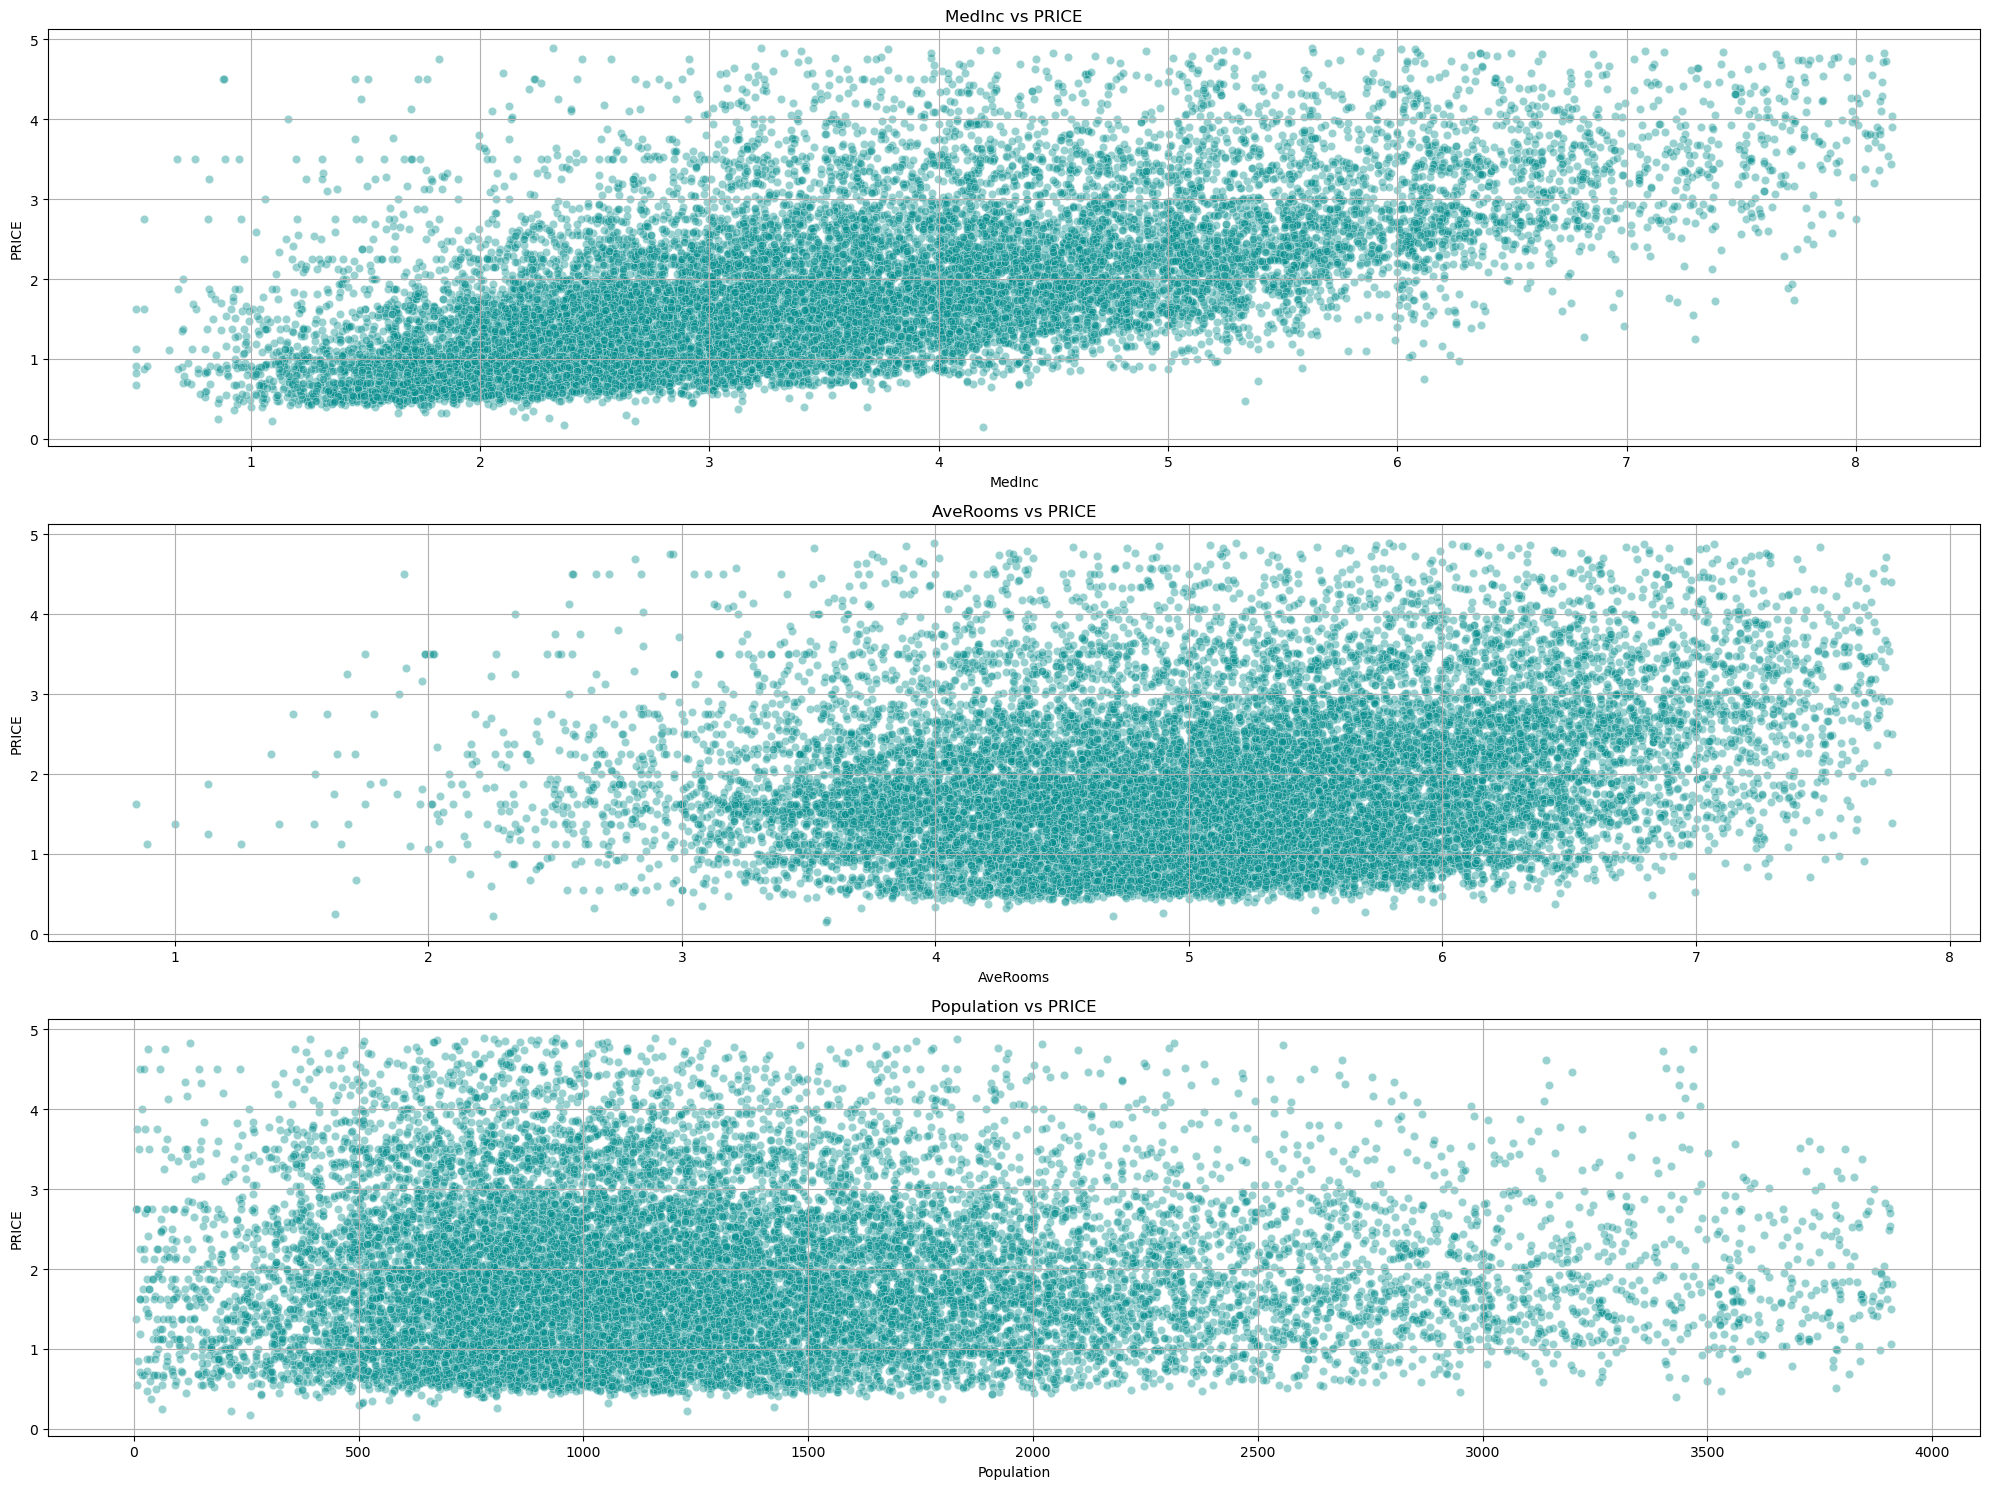

In [24]:
def plot_scatter_with_target(df, target='PRICE'):
    # Chọn các cột số để vẽ
    numerical_cols = ["MedInc", "AveRooms", "Population"]

    # Số hàng và cột
    n_cols = 1
    n_rows = len(numerical_cols)

    # Tạo subplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    
    # Nếu chỉ có 1 plot thì axes không phải là list
    if n_rows == 1:
        axes = [axes]

    # Vẽ scatter plot cho từng biến
    for i, feature in enumerate(numerical_cols):
        sns.scatterplot(x=df[feature], y=df[target], alpha=0.4, color='darkcyan', ax=axes[i])
        axes[i].set_title(f'{feature} vs {target}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm
plot_scatter_with_target(data_binned)


#### **Nhận xét chi tiết từng biến:**

##### 1. **MedInc (Median Income) vs PRICE**
- Mối quan hệ **tương đối rõ ràng và tuyến tính dương**: thu nhập trung vị càng cao → giá nhà càng cao.
- Mật độ điểm dữ liệu dày cho thấy phân phối tương đối đều, không có nhiều outlier bất thường.
- Đây là **biến có sức phân biệt mạnh nhất** đối với `PRICE`, nên được ưu tiên giữ lại.

##### 2. **AveRooms (Average Rooms) vs PRICE**
- Mối quan hệ **rải rác và yếu**, tuy nhiên có xu hướng rất nhẹ theo hướng dương (nhiều phòng hơn → giá có thể cao hơn).
- Dữ liệu khá phân tán, đặc biệt ở vùng trung tâm (từ 4–6 phòng), nhưng không thể hiện rõ xu hướng tuyến tính.
- Có thể cân nhắc giữ lại nếu được kết hợp với các biến khác như `AveBedrms` để tạo biến mới (ví dụ: tỉ lệ phòng ngủ/phòng tổng).

##### 3. **Population vs PRICE**
- Không thấy **mối quan hệ tuyến tính rõ rệt**.
- Dữ liệu trải dài trên toàn trục `Population`, nhưng `PRICE` chủ yếu tập trung từ 1 đến 3 bất kể dân số.
- Sự không tương quan này cho thấy **Population đơn lẻ không giúp giải thích `PRICE` tốt**.
- Có thể giữ lại nếu kết hợp thêm với vùng địa lý (Latitude, Longitude) để kiểm tra phân cụm dân cư và ảnh hưởng đến giá nhà.

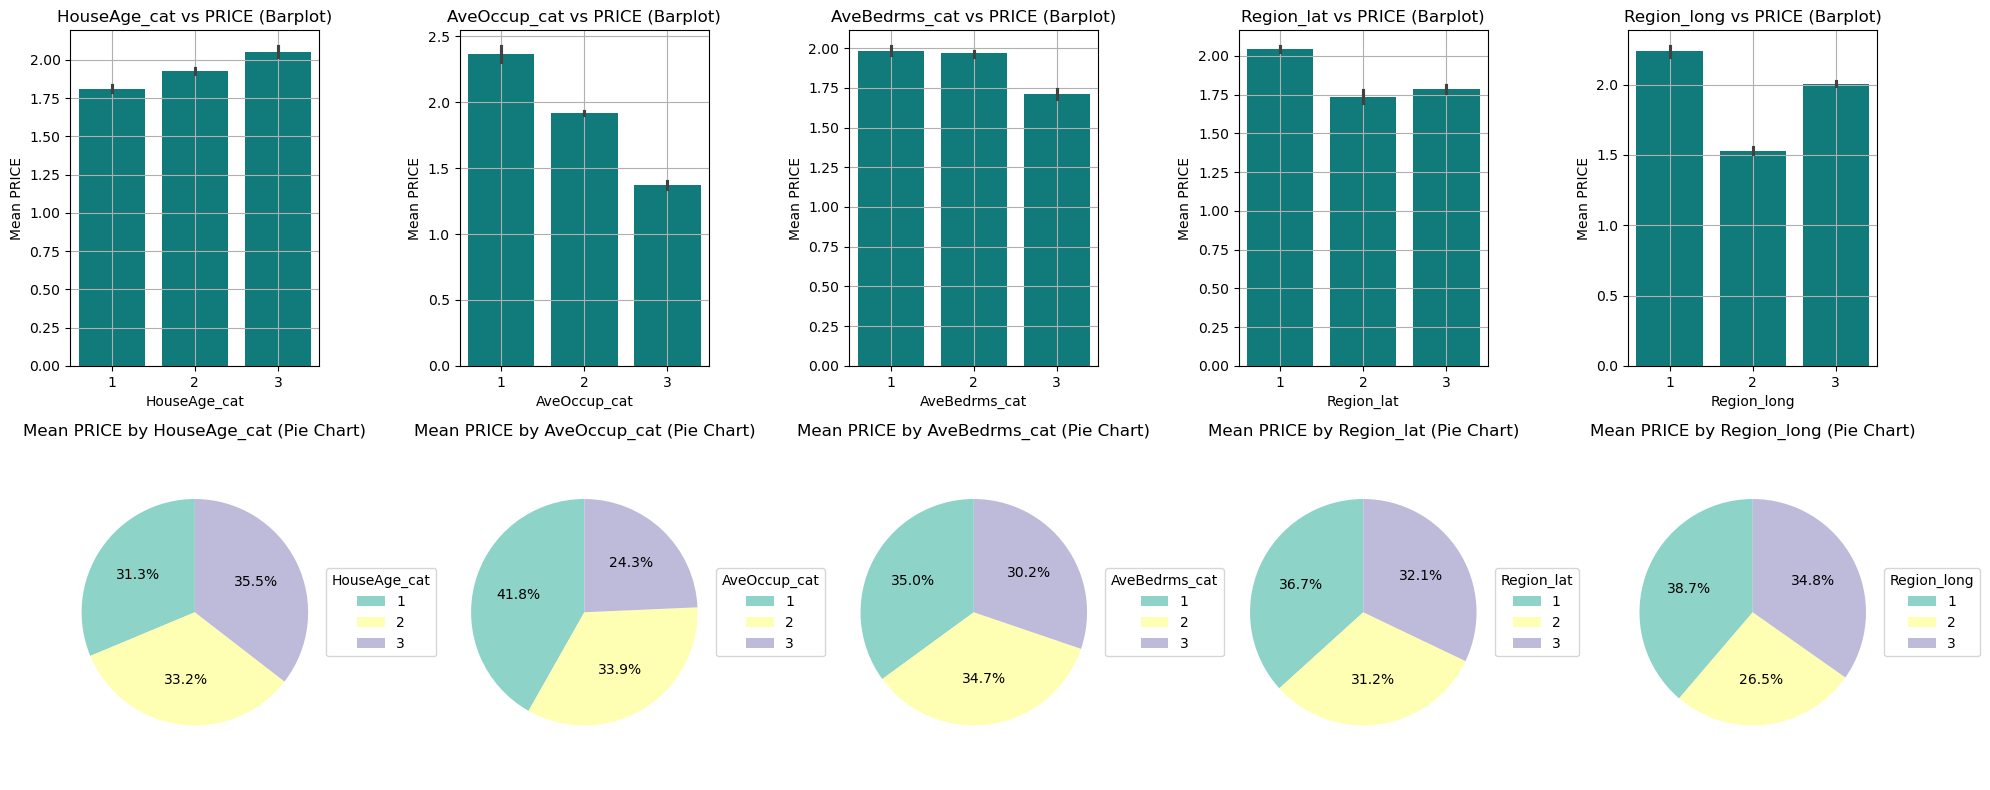

In [25]:
def plot_bar_and_pie_with_target(df, target='PRICE'):
    # Lọc các biến định tính
    categorical_cols = df.select_dtypes(include=['category']).columns.tolist()

    # Tạo các subplot
    fig, axes = plt.subplots(2, len(categorical_cols), figsize=(20, 8))  # 2 hàng cho bar và pie

    if len(categorical_cols) == 1:
        axes = [axes]  # Đảm bảo axes là list nếu chỉ có một biến

    # Vẽ barplot và pie chart cho từng biến định tính
    for i, feature in enumerate(categorical_cols):
        # Barplot
        sns.barplot(x=df[feature], y=df[target], color='darkcyan', ax=axes[0, i])
        axes[0, i].set_title(f'{feature} vs {target} (Barplot)')
        axes[0, i].set_xlabel(feature)
        axes[0, i].set_ylabel(f'Mean {target}')
        axes[0, i].grid(True)

        # Biểu đồ tròn (Pie chart)
        mean_price_by_category = df.groupby(feature)[target].mean()
        wedges, texts, autotexts = axes[1, i].pie(mean_price_by_category, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(mean_price_by_category)))

        # Thêm tiêu đề và chú thích cho pie chart
        axes[1, i].set_title(f'Mean {target} by {feature} (Pie Chart)')
        axes[1, i].axis('equal')  # Đảm bảo hình tròn đúng tỉ lệ
        labels = mean_price_by_category.index  # Tên các nhóm
        axes[1, i].legend(wedges, labels, title=feature, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.tight_layout()  # Cải thiện việc sắp xếp các biểu đồ
    plt.show()

# Vẽ barplot và pie chart giữa các biến định tính và `PRICE`
plot_bar_and_pie_with_target(data_binned)



**Nhận xét mối quan hệ giữa các biến phân loại và `PRICE`**

##### 1. **HouseAge_cat vs PRICE**
- **Bar chart** cho thấy:
  - `HouseAge_cat = 3` (tức nhà cũ hơn) có giá nhà trung bình **cao nhất**.
  - `HouseAge_cat = 1` (nhà mới hơn) lại thấp hơn.
- Điều này gợi ý rằng **khu vực có nhà lâu đời có thể là khu đắt đỏ hơn** (trung tâm đô thị hoặc khu cổ).
- **Pie chart**: Các nhóm tuổi nhà được phân bố tương đối đều (32% – 35%).
**Có mối quan hệ nhẹ giữa tuổi nhà và giá** – không tuyến tính nhưng đáng cân nhắc.

##### 2. **AveOccup_cat vs PRICE**
- **Rõ ràng có xu hướng nghịch đảo**:
  - Càng nhiều người ở mỗi hộ → giá nhà trung bình càng thấp.
- Điều này có thể phản ánh khu vực **mật độ cư trú cao thường ít cao cấp hơn**.
*Mối quan hệ nghịch chiều hợp lý*, nên giữ lại biến này.

##### 3. **AveBedrms_cat vs PRICE**
- Giá trung bình giữa 3 nhóm khá **tương đương** (không chênh lệch rõ rệt).
- Có thể **biến này không có sức phân biệt cao** sau khi đã binned.
**Không có mối quan hệ rõ**, cần cân nhắc giữ/lược bỏ.
-> Sẽ được chueyẻn thành biến tỷe lệ phòng ngủ trên phòng tổng!

##### 4. **Region_lat vs PRICE**
- Khu vực theo **latitude** có chênh lệch giá:
  - `Region_lat = 1` cao nhất → đây có thể là miền Nam California (vĩ độ thấp, gần LA)
  - `Region_lat = 2` thấp nhất → có thể là miền trung nội địa
- **Pie chart**: Các vùng địa lý chia đều, đảm bảo cân bằng nhóm.
**Mối quan hệ địa lý rõ ràng** – rất nên giữ.

##### 5. **Region_long vs PRICE**
- `Region_long = 1` có giá cao nhất, sau đó là 3, thấp nhất là 2.
- Điều này phản ánh sự khác biệt theo **vị trí đông–tây**, có thể liên quan đến khoảng cách biển.
- **Pie chart** cho thấy nhóm 2 chiếm tỷ lệ thấp nhất (~28.3%) nhưng có giá trung bình thấp nhất.
**Rất phù hợp với giả định địa lý → mạnh mẽ về ý nghĩa và logic**.

==> Các dữ liệu về vĩ độ sẽ được dùng để bỏ vào tableau và trực quan sau!

In [26]:
data_binned['bedroom_ratio'] = data_binned['AveBedrms'] / data_binned['AveRooms']
# Tách cột 'PRICE' ra
price_col = data_binned.pop('PRICE')
# Gán lại vào cuối DataFrame
data_binned['PRICE'] = price_col

In [27]:
data_binned

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseAge_cat,AveOccup_cat,AveBedrms_cat,Region_lat,Region_long,bedroom_ratio,PRICE
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3,2,2,3,1,0.18,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3,2,2,3,1,0.17,3.42
5,4.04,52.0,4.76,1.10,413.0,2.14,37.85,-122.25,3,2,3,3,1,0.23,2.70
6,3.66,52.0,4.93,0.95,1094.0,2.13,37.84,-122.25,3,2,1,3,1,0.19,2.99
7,3.12,52.0,4.80,1.06,1157.0,1.79,37.84,-122.25,3,1,2,3,1,0.22,2.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20634,3.71,28.0,6.78,1.15,1041.0,3.03,39.27,-121.56,2,2,3,3,2,0.17,1.17
20635,1.56,25.0,5.05,1.13,845.0,2.56,39.48,-121.09,2,2,3,3,2,0.22,0.78
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22,1,2,3,3,2,0.22,0.92
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32,1,2,3,3,2,0.22,0.85


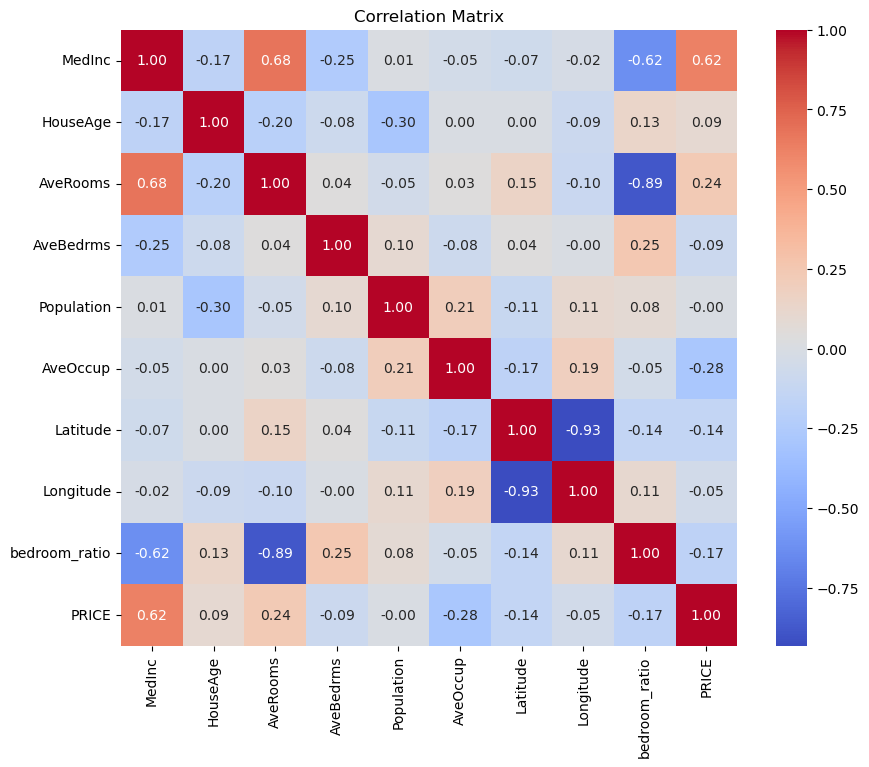

In [28]:
corr_matrix = data_binned.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [42]:
corr_index = data.corr(numeric_only=True)['PRICE'].sort_values(key=lambda x: x.abs(), ascending=False).drop('PRICE').head(5)
corr_index

MedInc           0.62
AveOccup        -0.28
AveRooms         0.24
bedroom_ratio   -0.17
Latitude        -0.14
Name: PRICE, dtype: float64

In [43]:
df_corr = corr_index.reset_index()
df_corr.columns = ['Variable', 'Correlation_with_PRICE']

# Xuất ra CSV
df_corr.to_csv('top5_correlations.csv', index=False)

### tổng kết
* Như hình trên, ta có thể thấy là trung bình thu nhập ảnh hưởng trực tiếp tới biến mục tiêu.
* Theo sau đó là biến trung bình số người trong gia đình, 1 biến thú vị nghịch chiều với biến mục tiêu.
* Tiếp theo là biến số phòng, 1 biến cũng quan trọng không kém ảnh hưởng tới gia cả căn nhà.
* Vị trí ngôi nhà cũng quan trọng với biến mục tiêu mà có lẽ k dc thể hiện rõ trong này.

## 3. Xây dựng mô hình hồi quy tuyến tính đa biến để dự đoán giá nhà

### a. Xây dựng mô hình đơn giản từ tất cả các biến

In [30]:
# 1. Xác định biến đầu vào và biến mục tiêu
X = data_binned.drop(columns=['PRICE'])  # Loại bỏ các cột định tính gốc
y = data_binned['PRICE']  # Biến mục tiêu

# 2. Chuẩn hóa dữ liệu (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Chuẩn hóa các biến đầu vào

# 3. Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Xây dựng mô hình hồi quy tuyến tính
from sklearn.linear_model import LinearRegression #Import Linear Regression here
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# 6. Đánh giá mô hình
from sklearn.metrics import mean_squared_error, r2_score #Import mean_squared_error and r2_score here
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

# In kết quả
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 0.31147417920323633
Mean Absolute Error (MAE): 0.4171175110640116
R-squared: 0.6481268558911194



#### **1. R-squared = 0.6748 → chỉ giải thích được 67.5% phương sai**
- Nghĩa là **vẫn còn đến 32.5% dao động trong giá nhà không được mô hình lý giải**.
- Với một bài toán **dự đoán giá – vốn rất nhạy cảm về độ chính xác**, thì đây **không phải là con số lý tưởng**.
- Trong ngành bất động sản, sai lệch nhỏ cũng dẫn đến chênh lệch hàng chục nghìn USD.

#### **2. MSE = 0.041 trên dữ liệu đã chuẩn hóa**
- Dữ liệu được chuẩn hóa (standardization), nên `PRICE` không còn ở đơn vị gốc → **MSE không có ý nghĩa trực tiếp về mặt tiền tệ**.
- Nhưng nếu so sánh tương đối, con số 0.041 vẫn là **khá lớn** nếu kỳ vọng mô hình tuyến tính có thể “bắt trọn” xu hướng dữ liệu.

#### **3. Mô hình tuyến tính quá đơn giản cho dữ liệu dạng này**
- Thị trường nhà đất mang nhiều yếu tố **phi tuyến tính, tương tác phức tạp** (thu nhập, vị trí, mật độ, pháp lý...).
- Hồi quy tuyến tính **không thể học được các quan hệ này** → dễ underfit (mô hình quá đơn giản).

> Mặc dù mô hình hồi quy tuyến tính đạt được hệ số R² = 0.6748 – cho thấy khả năng giải thích tương đối mối quan hệ giữa đặc trưng và biến mục tiêu – song kết quả này vẫn còn **hạn chế khi đặt trong bối cảnh ứng dụng thực tiễn**. Giá trị MSE 0.041 cho thấy sai số bình phương trung bình tuy không quá lớn sau chuẩn hóa, nhưng xét theo khía cạnh chính xác dự báo giá bất động sản, thì **mức độ khớp mô hình chưa thật sự thỏa đáng**. Điều này phản ánh rõ ràng rằng **mối quan hệ giữa đặc trưng và giá nhà mang tính phi tuyến**, đòi hỏi các mô hình phức tạp hơn để khai thác tốt hơn cấu trúc ẩn của dữ liệu.


### b. Kiểm tra 

#### Không đa cộng tuyến mạnh: tính hệ số VIF cho các biến đầu vào

In [31]:
def calculate_vif(X, threshold=8.0):
    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_with_const.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_with_const.values, i)
        for i in range(X_with_const.shape[1])
    ]
    # Bỏ cột 'const' khỏi kết quả
    vif_data = vif_data[vif_data['feature'] != 'const']

    # Lọc nếu vượt threshold
    return vif_data[vif_data['VIF'] > threshold].sort_values(by='VIF', ascending=False)

calculate_vif(X)

,feature,VIF
8,Longitude,18.18
7,Latitude,17.96
12,Region_lat,11.76
3,AveRooms,10.34
13,Region_long,8.26


Qua đây nhóm thấy có xu hướng đa cộng tuyến mạnh với xu hướng giá nhà tăng theo từng khu vực

### c. Tạo các biến mới

#### Tạo thêm các biến mới như bình phương diện tích, tích giữa diện tích và số phòng ngủ để cải thiện khả năng dự đoán

In [32]:
# Thêm biến MedInc^2 (thu nhập bình phương)
data_binned['med_squared'] = data_binned['MedInc'] ** 2

In [33]:
central_lat = 36.778259
central_lon = -119.417931

# Tính khoảng cách tương đối dạng Euclidean
data_binned['Distance_to_Center'] = np.sqrt(
    (data_binned['Latitude'] - central_lat)**2 +
    (data_binned['Longitude'] - central_lon)**2
)

**Biến mới thêm:**

- `med_squared`: Biến này là bình phương của biến `MedInc` (thu nhập trung vị). Mục đích của việc tạo biến này là để kiểm tra khả năng tồn tại quan hệ phi tuyến giữa thu nhập và biến mục tiêu. Việc giả định mối quan hệ giữa `MedInc` và giá trị mục tiêu là tuyến tính bậc 1 có thể chưa đủ chính xác. Do đó, biến `med_squared` được đưa vào như một ứng viên để mô hình có thể nắm bắt được ảnh hưởng tiềm năng theo dạng bậc hai (phi tuyến).

- `Distance_to_Center`: Biến này biểu thị khoảng cách Euclidean giữa mỗi quan sát và tọa độ trung tâm được chọn (trung tâm bang **California** – vĩ độ 36.778259, kinh độ -119.417931). Mục đích của biến này là kiểm tra xem vị trí địa lý – đặc biệt là độ gần trung tâm – có ảnh hưởng như thế nào đến giá trị mục tiêu (ví dụ: giá nhà). Biến này giúp mô hình định lượng hóa yếu tố khoảng cách thay vì chỉ sử dụng vĩ độ và kinh độ thuần túy.

### d. Tinh chỉnh mô hình

#### Sử dụng kỹ thuật Ridge và Lasso để giảm hiện tượng overfitting và xử lý đa cộng tuyến

In [34]:
calculate_vif(data_binned)

,feature,VIF
1,MedInc,26.22
16,med_squared,23.63
8,Longitude,21.13
7,Latitude,19.75
12,Region_lat,11.90
3,AveRooms,10.95
14,bedroom_ratio,8.59
13,Region_long,8.37


##### Kết luận từ bảng VIF:
* Các biến MedInc (26.22) và med_squared (23.63) có mức đa cộng tuyến cực kỳ cao.
* Tuy nhiên, vì MedInc (thu nhập trung bình) là biến dễ hiểu, dễ giải thích hơn so với med_squared (thu nhập bình phương), ta sẽ giữ MedInc và loại bỏ phần còn lại trong danh sách có VIF > 10.

In [35]:
data = data_binned.drop(columns=['med_squared', 'Region_lat', 'Region_long'])
data_binned.drop(columns=['med_squared', 'Longitude', 'Latitude', 'Region_lat', 'Region_long'], inplace= True)

In [36]:
def run_ridge_cv(data_binned, alpha=0.1, k_fold=0, return_score=False):
    # 1. Loại các biến địa lý, giữ lại Distance_to_Center
    X = data_binned.drop(columns=['PRICE'])
    y = data_binned['PRICE'].values

    # 2. Nếu không dùng KFold
    if k_fold == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

    else:
        # 3. Nếu dùng KFold
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
        rmse_train_list, rmse_test_list = [], []
        mae_train_list, mae_test_list = [], []
        r2_train_list, r2_test_list = [], []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = Ridge(alpha=alpha)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

            rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            rmse_test_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_train_list.append(mean_absolute_error(y_train, y_train_pred))
            mae_test_list.append(mean_absolute_error(y_test, y_test_pred))
            r2_train_list.append(r2_score(y_train, y_train_pred))
            r2_test_list.append(r2_score(y_test, y_test_pred))

        train_rmse = np.mean(rmse_train_list)
        test_rmse = np.mean(rmse_test_list)
        train_mae = np.mean(mae_train_list)
        test_mae = np.mean(mae_test_list)
        train_r2 = np.mean(r2_train_list)
        test_r2 = np.mean(r2_test_list)

    if return_score:
        return test_r2

    # 4. In kết quả
    print("Ridge Regression Results" + (" (K-Fold CV)" if k_fold > 0 else " (Train-Test Split)"))
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE : {train_mae:.4f}, Test MAE : {test_mae:.4f}")
    print(f"Train R²  : {train_r2:.4f}, Test R²  : {test_r2:.4f}")

In [37]:
def run_lasso_cv(data_binned, alpha=0.0001, k_fold=0, return_score=False):
    # 1. Loại các biến địa lý, giữ lại Distance_to_Center
    X = data_binned.drop(columns=['PRICE'])
    y = data_binned['PRICE'].values

    # 2. Chuẩn hóa toàn bộ dữ liệu (nếu k_fold > 0 thì chuẩn hóa từng fold)
    if k_fold == 0:
        # Train-Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Lasso(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

    else:
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
        rmse_train_list, rmse_test_list = [], []
        mae_train_list, mae_test_list = [], []
        r2_train_list, r2_test_list = [], []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = Lasso(alpha=alpha)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

            rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            rmse_test_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_train_list.append(mean_absolute_error(y_train, y_train_pred))
            mae_test_list.append(mean_absolute_error(y_test, y_test_pred))
            r2_train_list.append(r2_score(y_train, y_train_pred))
            r2_test_list.append(r2_score(y_test, y_test_pred))

        train_rmse = np.mean(rmse_train_list)
        test_rmse = np.mean(rmse_test_list)
        train_mae = np.mean(mae_train_list)
        test_mae = np.mean(mae_test_list)
        train_r2 = np.mean(r2_train_list)
        test_r2 = np.mean(r2_test_list)

    if return_score:
        return test_r2

    # In kết quả
    print("Lasso Regression Results" + (" (K-Fold CV)" if k_fold > 0 else " (Train-Test Split)"))
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE : {train_mae:.4f}, Test MAE : {test_mae:.4f}")
    print(f"Train R²  : {train_r2:.4f}, Test R²  : {test_r2:.4f}")

### e. Đánh giá mô hình bằng K-Fold Cross Validation

#### Sử dụng K-fold để kiểm tra độ ổn định mô hình

In [38]:
%%time
# Gọi lại hàm với alpha
run_lasso_cv(
    data_binned,
    alpha=0.0001,
    k_fold=5
)
run_ridge_cv(
    data_binned,
    alpha=0.0001,
    k_fold=5    
)

Lasso Regression Results (K-Fold CV)
Train RMSE: 0.6206, Test RMSE: 0.6211
Train MAE : 0.4696, Test MAE : 0.4699
Train R²  : 0.5682, Test R²  : 0.5672
Ridge Regression Results (K-Fold CV)
Train RMSE: 0.6206, Test RMSE: 0.6211
Train MAE : 0.4696, Test MAE : 0.4699
Train R²  : 0.5682, Test R²  : 0.5672
CPU times: total: 1.62 s
Wall time: 197 ms


#### Báo cáo các chỉ số đánh giá: hệ số xác định R bình phương (R²), sai số tuyệt đối trung bình (MAE) và căn sai số bình phương trung bình (RMSE)

##### **Kết quả tổng hợp:**

| Mô hình          | Train RMSE  | Test RMSE  | Train MAE | Test MAE  | Train R² | Test R² |
|------------------|-------------|------------|-----------|-----------|----------|---------|
| **Lasso**        | 0.6206      | 0.6211     | 0.4696    | 0.4699    | 0.5682   | 0.5672  |
| **Ridge**        | 0.6206      | 0.6211     | 0.4696    | 0.4699    | 0.5682   | 0.5672  |

##### **Đánh giá và phân tích:**

- **Hiệu suất của Lasso và Ridge trùng khớp** về mọi chỉ số, cho thấy rằng trong ngữ cảnh tập dữ liệu hiện tại, **tác động của chuẩn L1 và chuẩn L2 đến kết quả mô hình là không đáng kể**.

- **Độ lệch giữa tập huấn luyện và kiểm định rất nhỏ** (chênh lệch R² < 0.001), chứng tỏ mô hình có tính ổn định cao, không gặp vấn đề nghiêm trọng về overfitting hoặc underfitting.

- Tuy nhiên, giá trị **R² chỉ đạt khoảng 56%-57%**, đồng nghĩa với việc mô hình tuyến tính – dù đã được regularization – **vẫn chưa đủ khả năng lý giải đầy đủ mối quan hệ giữa các đặc trưng và biến mục tiêu (`PRICE`)**.

##### **Kết luận:**

> Mô hình Lasso và Ridge tuy đạt được mức độ ổn định cao, nhưng kết quả R² thấp cho thấy **sự hạn chế cố hữu của mô hình tuyến tính trong bối cảnh dữ liệu có mối quan hệ phi tuyến và phức tạp như thị trường nhà đất**. Có thể chuyển sang mô hình dạng phi tuyến hoặc nâng cao hơn là các mô hình blackbox.

# Tóm tắt kết quả

Trong khuôn khổ đề tài, nhóm đã thực hiện một chuỗi các bước phân tích dữ liệu và mô hình hóa dự báo giá nhà tại California một cách hệ thống, gồm 4 giai đoạn chính:

#### **1. Tiền xử lý dữ liệu**  
**Thực hiện:** Tải dữ liệu từ `fetch_california_housing`, xử lý thiếu, loại bỏ ngoại lai, chuyển đổi định dạng và tạo thêm biến mới.  
**Kết quả đạt được:**  
- Tập dữ liệu sạch, không còn giá trị bất thường.  
- Các biến phân loại được mã hóa phù hợp, sẵn sàng cho mô hình hóa.  
- Một số đặc trưng mới như biến kết hợp, biến phân cụm được đưa vào thử nghiệm.

#### **2. Khám phá dữ liệu và trực quan hóa**  
**Thực hiện:** Vẽ biểu đồ phân phối, scatter plot giữa các biến và biến mục tiêu (`PRICE`)
**Kết quả đạt được:**  
- Nhận diện được các đặc trưng có tương quan rõ với giá nhà (MedInc, Distance_to_Center...).  
- Nhận diện được các phân phối xấu của dữ liệu, tinh chỉnh các phân phối để đưa gần về thực tế
- 
#### **3. Xây dựng và đánh giá mô hình hồi quy tuyến tính**  
**Thực hiện:** Triển khai hồi quy đa biến, kiểm định giả định mô hình (phân phối phần dư, đa cộng tuyến), áp dụng Ridge & Lasso, đánh giá bằng K-Fold CV.  
**Kết quả đạt được:**  
- Mô hình ổn định, không vi phạm giả định nghiêm trọng.  
- Tuy nhiên, R² chỉ đạt ~0.5982 trên tập kiểm định → mô hình không giải thích tốt sự biến động của giá nhà.  
- Ridge & Lasso không cải thiện đáng kể → dữ liệu có tính phi tuyến rõ rệt.
- **Xác định MedInc là đặc trưng ảnh hưởng lớn nhất**, phù hợp lý thuyết kinh tế nhà đất.
#### Hướng tiếp theo
- Xuất file, sử dụng tool dể tiếp tục trực quan hóa dữ liệu, giúp người dùng hiểu rõ hơn về các lý thuyết kinh tế và đưa ra lời khuyên cho người dân xung quanh đặc biệt là giới trẻ làm sao để mua được nhà khu vực đó!

In [39]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseAge_cat,AveOccup_cat,AveBedrms_cat,bedroom_ratio,PRICE,Distance_to_Center
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3,2,2,0.18,3.41,3.03
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3,2,2,0.17,3.42,3.03
5,4.04,52.0,4.76,1.10,413.0,2.14,37.85,-122.25,3,2,3,0.23,2.70,3.03
6,3.66,52.0,4.93,0.95,1094.0,2.13,37.84,-122.25,3,2,1,0.19,2.99,3.02
7,3.12,52.0,4.80,1.06,1157.0,1.79,37.84,-122.25,3,1,2,0.22,2.41,3.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20634,3.71,28.0,6.78,1.15,1041.0,3.03,39.27,-121.56,2,2,3,0.17,1.17,3.29
20635,1.56,25.0,5.05,1.13,845.0,2.56,39.48,-121.09,2,2,3,0.22,0.78,3.18
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22,1,2,3,0.22,0.92,3.21
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32,1,2,3,0.22,0.85,3.26


In [40]:
data.to_csv("fetch_california_housing_modify.csv", index=False)